<table style="width:100%; text-align:center;">
  <tr>
    <th style="text-align:center;" colspan="2">CSC 562: AI Research Project Assignment</th>
  </tr>
  <tr>
    <td style="text-align:center;" colspan="2">From Data to Decisions: Utilizing a Hybrid Deep Learning and Deep Reinforcement Learning Approach for Bitcoin Trading</td>
  </tr>
  <tr>
    <th style="text-align:center;">Name</th>

  </tr>
  <tr>
    <td style="text-align:center;">Alanoud Almajed</td>
  
  </tr>
   <tr>
    <td style="text-align:center;">Reem Alshehri</td>
   
  </tr>
  
    
</table>




# **1.	Data Collection**

In [32]:
# Importing libraries
import requests  # For making HTTP requests
from bs4 import BeautifulSoup  # For web scraping
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For enhanced data visualization


### **1.1 Historical BTC prices:**
The dataset includes daily Bitcoin prices from May 2018 to September 2024 from Investing.com

Source Link:https://www.investing.com/indices/investing.com-btc-usd

In [33]:
# Load dataset
BTC_USD_Historical_Data = pd.read_csv('BTC_USD Historical Data.csv')

# Rename columns in BTC data
BTC_USD_Historical_Data = BTC_USD_Historical_Data.rename(columns={
    'Price': 'BTC_Price',
    'Open': 'BTC_Open',
    'High': 'BTC_High',
    'Low': 'BTC_Low',
    'Vol.': 'BTC_Vol.',
    'Change': 'BTC_Change'
})

BTC_USD_Historical_Data

,Date,BTC_Price,BTC_Open,BTC_High,BTC_Low,BTC_Vol.,Change %
0,09/30/2024,"63,468.0","65,762.0","65,762.0","63,006.0",1.04K,-3.49%
1,09/29/2024,"65,762.0","66,015.0","66,193.0","65,574.0",0.09K,-0.38%
2,09/28/2024,"66,015.0","65,928.0","66,410.0","65,568.0",0.11K,0.13%
3,09/27/2024,"65,928.0","65,307.0","66,548.0","64,987.0",0.67K,0.95%
4,09/26/2024,"65,307.0","63,264.0","65,856.0","62,805.0",0.86K,3.23%
...,...,...,...,...,...,...,...
3554,01/05/2015,273.2,261.0,276.5,260.5,2.68K,5.57%
3555,01/04/2015,258.8,282.0,288.9,258.8,2.38K,-8.23%
3556,01/03/2015,282.0,314.8,314.8,282.0,1.30K,-10.51%
3557,01/02/2015,315.1,313.6,316.0,313.0,1.32K,0.40%


### **1.2	Economic Indicators:**
Data on various economic indicators, including  S&P 500, oil prices, gold prices, and other relevant economic variables.

### For brent_oil, using API to extract data from a website.
Source link: BrentOil_Price	USING API (https://www.eia.gov/opendata/browser/petroleum/pri/spt?frequency=daily&data=value;&facets=series;&series=RBRTE;&sortColumn=period;&sortDirection=desc;)

In [34]:
# For brent_oil, we used API to extract data from a website

# API Data Fetch: Brent Oil
url = "https://api.eia.gov/v2/petroleum/pri/spt/data/"
params = {
    "api_key": "ID2PfupJmuavOIyurfbifgqnSUItjTtwWQCjyJcM",
    "frequency": "daily",
    "data[0]": "value",
    "facets[series][]": "RBRTE",
    "start": "2015-01-01",
    "end": "2024-09-30",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000
}

# Fetch the data
response = requests.get(url, params=params)
if response.status_code == 200:
    data = response.json()
    records = data.get("response", {}).get("data", [])
    brent_oil = pd.DataFrame(records)[['period', 'value']].rename(
        columns={'period': 'Date', 'value': 'BrentOil_Price'}
    )
    brent_oil['Date'] = pd.to_datetime(brent_oil['Date'])
    brent_oil.to_excel("BrentOil.xlsx", index=False)
    print("Brent Oil data saved to 'BrentOil.xlsx'")
else:
    print(f"Failed to fetch Brent Oil data. Status code: {response.status_code}")


Brent Oil data saved to 'BrentOil.xlsx'


Source links:
- DowJones_Price: https://www.investing.com/indices/us-30-historical-data
- Nasdaq_Price:	https://www.investing.com/indices/nq-100-historical-data
- Gold_Price: https://www.investing.com/currencies/xau-usd-historical-data
- S&P 500 (SPX)	https://www.investing.com/indices/us-spx-500-historical-data

In [35]:
# Load Other Datasets
dowjones_data = pd.read_csv('Dow Jones .csv')
nasdaq_data = pd.read_csv('NASDAQ .csv')
gold_data = pd.read_excel('Gold.xlsx')
SP_data = pd.read_csv('S&P 500.csv')

# Convert Dates and Select Relevant Columns
datasets = [BTC_USD_Historical_Data, dowjones_data, nasdaq_data, gold_data, SP_data, brent_oil]
for df in datasets:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Select relevant columns and rename for consistency
dowjones_data = dowjones_data[['Date', 'Price']].rename(columns={'Price': 'DowJones_Price'})
nasdaq_data = nasdaq_data[['Date', 'Price']].rename(columns={'Price': 'Nasdaq_Price'})
SP_data = SP_data[['Date', 'Price']].rename(columns={'Price': 'S&P_Price'})


### **Merge for Historical BTC prices & Economic Indicators**

In [37]:
# Merge Datasets
# Merge all datasets using an outer join to preserve all dates
HE = BTC_USD_Historical_Data
HE = pd.merge(HE, dowjones_data, on='Date', how='outer')
HE = pd.merge(HE, nasdaq_data, on='Date', how='outer')
HE = pd.merge(HE, SP_data, on='Date', how='outer')
HE = pd.merge(HE, gold_data, on='Date', how='outer')
HE = pd.merge(HE, brent_oil, on='Date', how='outer')

# Sort data by date for consistency
HE = HE.sort_values(by='Date').reset_index(drop=True)

# Final Output
HE

,Date,BTC_Price,BTC_Open,BTC_High,BTC_Low,BTC_Vol.,Change %,DowJones_Price,Nasdaq_Price,S&P_Price,Gold_Price,BrentOil_Price
0,2015-01-01,313.9,317.5,317.5,312.9,0.93K,-0.99%,NaN,NaN,NaN,1185.4,NaN
1,2015-01-02,315.1,313.6,316.0,313.0,1.32K,0.40%,"17,832.99","4,726.81","2,058.20",1187.6,55.38
2,2015-01-03,282.0,314.8,314.8,282.0,1.30K,-10.51%,NaN,NaN,NaN,1189.8,NaN
3,2015-01-04,258.8,282.0,288.9,258.8,2.38K,-8.23%,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,273.2,261.0,276.5,260.5,2.68K,5.57%,"17,501.65","4,652.57","2,020.60",1204.0,51.08
...,...,...,...,...,...,...,...,...,...,...,...,...
3555,2024-09-26,"65,307.0","63,264.0","65,856.0","62,805.0",0.86K,3.23%,"42,175.11","18,190.29","5,745.37",2694.9,73.06
3556,2024-09-27,"65,928.0","65,307.0","66,548.0","64,987.0",0.67K,0.95%,"42,313.00","18,119.59","5,738.17",2644.3,71.63
3557,2024-09-28,"66,015.0","65,928.0","66,410.0","65,568.0",0.11K,0.13%,NaN,NaN,NaN,NaN,NaN
3558,2024-09-29,"65,762.0","66,015.0","66,193.0","65,574.0",0.09K,-0.38%,NaN,NaN,NaN,NaN,NaN


## **Pre-processing for Historical BTC prices & Economic Indicators**

In [38]:
# Step 1: Convert 'BTC_Vol.' to numeric using the existing function
def convert_volume(value):
    if isinstance(value, str):  # Only process strings
        if 'K' in value:
            return float(value.replace('K', '')) * 1_000  # Convert 'K' to thousands
        elif 'M' in value:
            return float(value.replace('M', '')) * 1_000_000  # Convert 'M' to millions
        elif 'B' in value:
            return float(value.replace('B', '')) * 1_000_000_000  # Convert 'B' to billions
        else:
            return float(value)  # Convert other strings to float
    return value  # Return the value as is if it's not a string

# Apply the function to the BTC_Vol. column
HE['BTC_Vol.'] = HE['BTC_Vol.'].apply(convert_volume)

In [39]:
# Step 2: Remove commas and strip whitespace from the columns, ensuring we work with strings first
columns_to_clean = ['BTC_Price', 'BTC_Open', 'BTC_High', 'BTC_Low', 'DowJones_Price', 'Nasdaq_Price', 'S&P_Price', 'BrentOil_Price']
for col in columns_to_clean:
    # Convert to string first (in case it has been converted to numeric) before applying string operations
    HE[col] = HE[col].astype(str).str.replace(',', '').str.strip()

# Step 3: Convert columns to numeric with error handling
numeric_columns = ['BTC_Price', 'BTC_Open', 'BTC_High', 'BTC_Low', 'BTC_Vol.',
                   'DowJones_Price', 'Nasdaq_Price', 'S&P_Price', 'Gold_Price', 'BrentOil_Price']

# Convert the columns to numeric, coercing errors into NaN
for col in numeric_columns:
    HE[col] = pd.to_numeric(HE[col], errors='coerce')

# Step 4: Clean 'Change %' column by converting to decimal
def clean_percentage(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '').strip()) / 100  # Convert to decimal
    return value

# Apply the percentage conversion function to 'Change %'
HE['Change %'] = HE['Change %'].apply(clean_percentage)

In [46]:
# Step 5: Reapply the conversion for all columns to ensure the 'Change %' is correctly converted
numeric_columns = ['BTC_Price', 'BTC_Open', 'BTC_High', 'BTC_Low', 'BTC_Vol.',
                   'DowJones_Price', 'Nasdaq_Price', 'S&P_Price', 'Gold_Price',
                   'BrentOil_Price', 'Change %']

# Convert all applicable columns to numeric types
for col in numeric_columns:
    HE[col] = pd.to_numeric(HE[col], errors='coerce')
HE.fillna(method='ffill', inplace=True)
HE = HE.dropna(subset=['BTC_Vol.'])
# Step 6: Inspect the DataFrame after preprocessing
HE

<ipython-input-46-5294e6b95a9e>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  HE.fillna(method='ffill', inplace=True)


,Date,BTC_Price,BTC_Open,BTC_High,BTC_Low,BTC_Vol.,Change %,DowJones_Price,Nasdaq_Price,S&P_Price,Gold_Price,BrentOil_Price
0,2015-01-01,313.9,317.5,317.5,312.9,930.0,-0.0099,NaN,NaN,NaN,1185.4,NaN
1,2015-01-02,315.1,313.6,316.0,313.0,1320.0,0.0040,17832.99,4726.81,2058.20,1187.6,55.38
2,2015-01-03,282.0,314.8,314.8,282.0,1300.0,-0.1051,17832.99,4726.81,2058.20,1189.8,55.38
3,2015-01-04,258.8,282.0,288.9,258.8,2380.0,-0.0823,17832.99,4726.81,2058.20,1189.8,55.38
4,2015-01-05,273.2,261.0,276.5,260.5,2680.0,0.0557,17501.65,4652.57,2020.60,1204.0,51.08
...,...,...,...,...,...,...,...,...,...,...,...,...
3555,2024-09-26,65307.0,63264.0,65856.0,62805.0,860.0,0.0323,42175.11,18190.29,5745.37,2694.9,73.06
3556,2024-09-27,65928.0,65307.0,66548.0,64987.0,670.0,0.0095,42313.00,18119.59,5738.17,2644.3,71.63
3557,2024-09-28,66015.0,65928.0,66410.0,65568.0,110.0,0.0013,42313.00,18119.59,5738.17,2644.3,71.63
3558,2024-09-29,65762.0,66015.0,66193.0,65574.0,90.0,-0.0038,42313.00,18119.59,5738.17,2644.3,71.63


### **Correlation matrix show relations between Bitcoin prices and economic indicators**

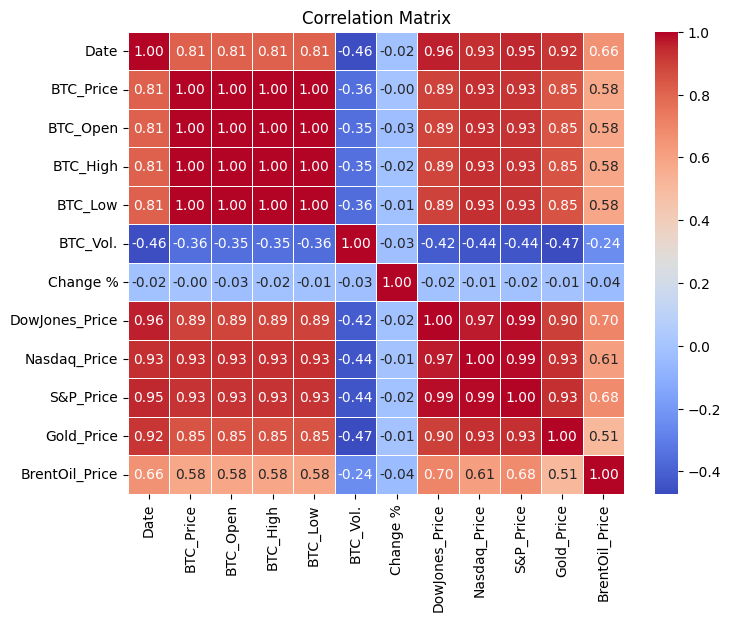

In [43]:
# Calculate the correlation matrix
correlation_matrix = HE.corr()

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# **1.2	Sentiment Analysis**
Sentiment analysis was done by web scraping over 2,700 pages of news articles about Bitcoin, extracting about 93,870 news titles using a natural language processing (NLP) model like bidirectional encoder representations from transformers (BERT).

Source link: https://www.investing.com/news/cryptocurrency-news


### **Web scraping for news:**

In [ ]:
# Base URL of the cryptocurrency news page
base_url = 'https://www.investing.com/news/cryptocurrency-news'

# Headers to simulate a browser visit
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.5938.132 Safari/537.36'
}

# Lists to store the data
all_times = []
all_titles = []

# Loop through the page range (from page 20 to 100)
for page_num in range(14,2700):  # Adjust range as needed
    # Construct the URL for the current page
    if page_num == 1:
        url = base_url  # The first page does not have a page number in the URL
    else:
        url = f"{base_url}/{page_num}"

    # Send the request
    response = requests.get(url, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        print(f"Successfully accessed page {page_num}")

        # Parse the HTML content
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find all time and title elements
        times = soup.find_all('time', {'data-test': 'article-publish-date'})
        titles = soup.find_all('a', {'data-test': 'article-title-link'})

        # Extract text and store in lists
        all_times.extend([time.get_text() for time in times])
        all_titles.extend([title.get_text() for title in titles])

    else:
        print(f"Failed to access page {page_num}")

# Create a DataFrame with the collected data
crypto_news = pd.DataFrame({
    'Time': all_times,
    'Title': all_titles
})

# Display the table
print(crypto_news)

In [50]:
crypto_news = pd.read_excel("crypto_news.xlsx")
crypto_news

,Date,Title
0,"Sep 30, 2024",Impossible Cloud Network Launches ICNT: The To...
1,"Sep 30, 2024",Former Binance CEO Speaks out After Prison Rel...
2,"Sep 30, 2024",De.Fi World 2024 Set to Convene Industry Leade...
3,"Sep 30, 2024","Bitcoin Bull Michael Saylor Flexes 1,325% Gain..."
4,"Sep 30, 2024",World Mobile Launches on Base to Expand Global...
...,...,...
93864,"May 14, 2018",Odyssey (OCN) Falls After Extraordinary Rally...
93865,"May 14, 2018",Thailand: Legal Framework For Cryptocurrencies...
93866,"May 14, 2018",CME Group in deal to offer ether reference rate
93867,"May 14, 2018","EXCLUSIVE: Q&A with Loi Luu, Founder & CEO of..."


### **Data was collected from news websites, and the sentiment of articles was analyzed and classified as positive, negative, or neutral**

In [ ]:
from tqdm import tqdm
from transformers import pipeline

# Load the BERT sentiment analysis pipeline
classifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Function to process a batch of texts and perform sentiment analysis
def process_batch(texts):
    results = classifier(texts, truncation=True, max_length=512)
    sentiments = []  # List to store sentiment labels
    scores = []  # List to store sentiment scores

    # Loop through results to classify and score each sentiment
    for res in results:
        label = res['label']
        score = res['score']
        # Categorize sentiment based on the star rating
        if label == "1 star" or label == "2 stars":
            sentiments.append("Negative")
            scores.append(-score)  # Negative sentiment score
        elif label == "4 stars" or label == "5 stars":
            sentiments.append("Positive")
            scores.append(score)  # Positive sentiment score
        else:
            sentiments.append("Neutral")
            scores.append(0)  # Neutral sentiment score

    return sentiments, scores

# Initialize a DataFrame to store results
news_analysis = crypto_news.copy()
news_analysis['Sentiment'] = None
news_analysis['Sentiment_Score'] = None

# Process the news titles in batches
batch_size = 32
for i in tqdm(range(0, len(crypto_news), batch_size), desc="Processing Batches"):
    # Extract a batch of titles
    batch_titles = crypto_news['Title'][i:i + batch_size].tolist()

    # Get sentiment results for the batch
    sentiments, scores = process_batch(batch_titles)

    # Store the sentiment labels and scores in the DataFrame
    news_analysis.loc[i:i + batch_size - 1, 'Sentiment'] = sentiments
    news_analysis.loc[i:i + batch_size - 1, 'Sentiment_Score'] = scores

# Display the resulting DataFrame with sentiments
print(news_analysis.head())


### **Aggregated all news for the same day to generate a single sentiment score per day**

Weighted Average Sentiment (mean of sentiment scores)

Most Influential Sentiment (based on highest absolute score)

Majority Sentiment (most common sentiment)



In [ ]:
# Define the function to aggregate sentiments by date
def aggregate_sentiment_by_date(group):
    # Calculate the Weighted Average Sentiment (mean of sentiment scores)
    weighted_average = group['Sentiment_Score'].mean()

    # Find the Most Influential Sentiment (based on highest absolute score)
    most_influential_row = group.loc[group['Sentiment_Score'].abs().idxmax()]
    most_influential = most_influential_row['Sentiment']

    # Find the Majority Sentiment (most common sentiment)
    majority_sentiment = group['Sentiment'].value_counts().idxmax()

    # Return the aggregated results as a pandas Series
    return pd.Series({
        'Weighted_Average_Sentiment': weighted_average,
        'Most_Influential_Sentiment': most_influential,
        'Majority_Sentiment': majority_sentiment
    })
# Group the news_analysis DataFrame by Date and apply the aggregation function
Sentiment_analysis = news_analysis.groupby('Time').apply(aggregate_sentiment_by_date).reset_index()


In [56]:
Sentiment_analysis = pd.read_excel("Sentiment_analysis.xlsx")
Sentiment_analysis

,Date,Weighted_Average_Sentiment,Most_Influential_Sentiment,Majority_Sentiment
0,2018-05-14,0.110124,Positive,Positive
1,2018-05-15,0.117673,Negative,Positive
2,2018-05-16,-0.044261,Negative,Negative
3,2018-05-17,0.007733,Positive,Positive
4,2018-05-18,0.022261,Negative,Positive
...,...,...,...,...
2309,2024-09-29,0.447328,Positive,Positive
2310,2024-09-30,-0.051526,Negative,Positive
2311,2024-11-08,-0.155391,Positive,Negative
2312,2024-11-09,-0.077508,Positive,Negative


# **Merge Datasets:**

### **Final result unified data set included:**
BTC prices & Economic Indicators & Sentiment Analysis

In [57]:
# Merge the datasets on the 'Date' column with 'inner' join
Dataset = pd.merge(HE , Sentiment_analysis, on='Date', how='inner')

# Reorder columns
sentiment_columns = ['Weighted_Average_Sentiment', 'Most_Influential_Sentiment', 'Majority_Sentiment']
remaining_columns = [col for col in Dataset.columns if col not in sentiment_columns]

Dataset = Dataset[remaining_columns + sentiment_columns]

# Display the resulting DataFrame
Dataset



,Date,BTC_Price,BTC_Open,BTC_High,BTC_Low,BTC_Vol.,Change %,DowJones_Price,Nasdaq_Price,S&P_Price,Gold_Price,BrentOil_Price,Weighted_Average_Sentiment,Most_Influential_Sentiment,Majority_Sentiment
0,2018-05-14,8670.8,8683.8,8882.4,8279.5,37150.0,-0.0015,24899.41,7411.31,2730.10,1313.20,78.17,0.110124,Positive,Positive
1,2018-05-15,8467.5,8668.5,8838.0,8420.7,26210.0,-0.0234,24706.41,7351.63,2711.40,1290.39,78.94,0.117673,Negative,Positive
2,2018-05-16,8336.1,8467.0,8488.7,8103.6,32760.0,-0.0155,24768.93,7398.30,2722.50,1290.63,78.19,-0.044261,Negative,Negative
3,2018-05-17,8051.8,8349.7,8466.9,7986.8,25190.0,-0.0341,24713.98,7382.47,2720.10,1290.73,80.09,0.007733,Positive,Positive
4,2018-05-18,8239.0,8054.8,8276.6,7927.8,23440.0,0.0232,24715.09,7354.34,2713.00,1291.30,78.38,0.022261,Negative,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2306,2024-09-26,65307.0,63264.0,65856.0,62805.0,860.0,0.0323,42175.11,18190.29,5745.37,2694.90,73.06,0.020917,Negative,Positive
2307,2024-09-27,65928.0,65307.0,66548.0,64987.0,670.0,0.0095,42313.00,18119.59,5738.17,2644.30,71.63,-0.120266,Negative,Negative
2308,2024-09-28,66015.0,65928.0,66410.0,65568.0,110.0,0.0013,42313.00,18119.59,5738.17,2644.30,71.63,-0.174357,Negative,Negative
2309,2024-09-29,65762.0,66015.0,66193.0,65574.0,90.0,-0.0038,42313.00,18119.59,5738.17,2644.30,71.63,0.447328,Positive,Positive


In [58]:
# Save the final dataset to a CSV file for download
Dataset.to_csv("Merged_Dataset.csv", index=False)